<a href="https://colab.research.google.com/github/kevinabraham23/odin-recipes/blob/main/HotdogNotHotdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets,layers, models

import tensorflow_datasets as tdfs

In [ ]:
ds, ds_info = tdfs.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete3J5RZU/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete3J5RZU/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds, valid_ds = ds["train"],ds["validation"]

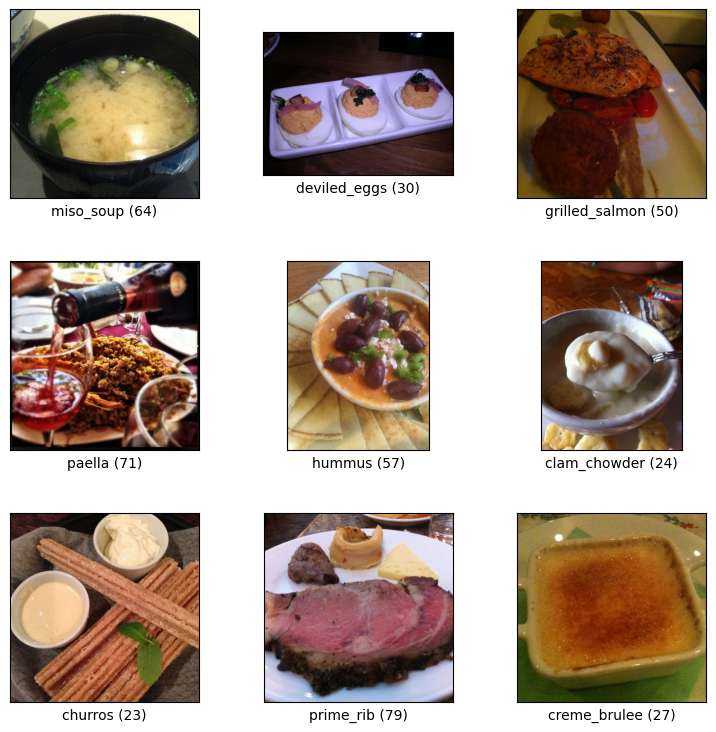

In [ ]:
fig = tdfs.show_examples(train_ds,ds_info)

In [ ]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

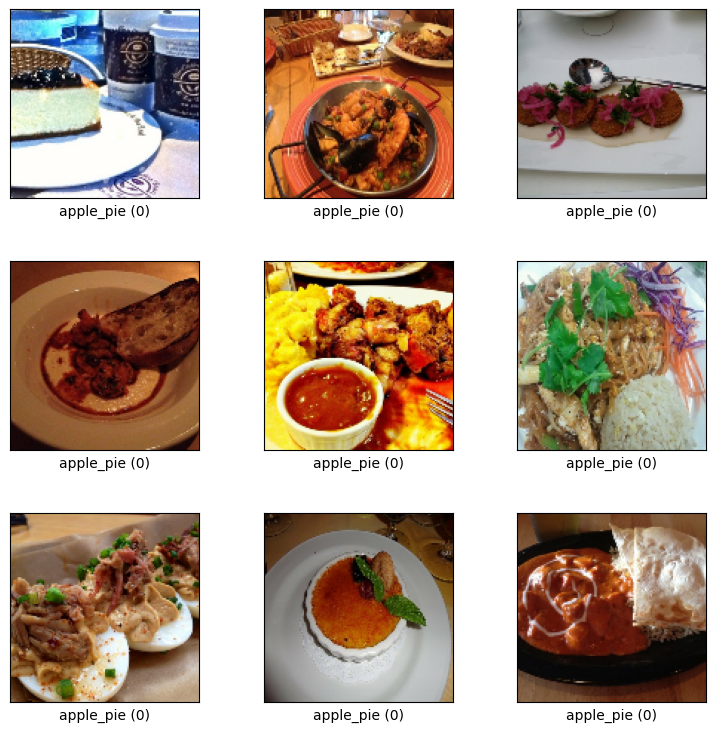

In [ ]:
fig = tdfs.show_examples(train_ds, ds_info)

In [ ]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [ ]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [ ]:
valid_hotdogs

<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image_batch,label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[233 235 232]
   [237 237 235]
   [238 237 237]
   ...
   [240 240 240]
   [243 243 243]
   [241 241 241]]

  [[233 235 232]
   [236 236 234]
   [237 236 236]
   ...
   [241 241 241]
   [242 242 242]
   [242 242 242]]

  [[236 238 235]
   [237 237 235]
   [235 234 235]
   ...
   [239 239 239]
   [242 242 242]
   [242 242 242]]

  ...

  [[237 238 232]
   [239 239 234]
   [234 233 228]
   ...
   [241 241 242]
   [242 242 243]
   [243 243 244]]

  [[238 239 233]
   [240 240 235]
   [236 235 230]
   ...
   [241 241 241]
   [242 242 242]
   [242 242 242]]

  [[241 242 236]
   [240 240 235]
   [240 239 234]
   ...
   [243 243 241]
   [244 244 242]
   [243 243 241]]]


 [[[224 226 225]
   [221 223 224]
   [225 226 229]
   ...
   [ 87  52  30]
   [ 85  52  30]
   [ 77  47  28]]

  [[225 228 230]
   [222 224 227]
   [218 220 224]
   ...
   [ 91  53  34]
   [ 83  46  28]
   [ 75  42  29]]

  [[220 223 227]
   [222 225 229]
   [212 215 221]
   ...
   [ 78  41  24]
   [ 75  39  26]


Neural networks implementation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
for i,_ in ds["train"].take(1):
  image=i

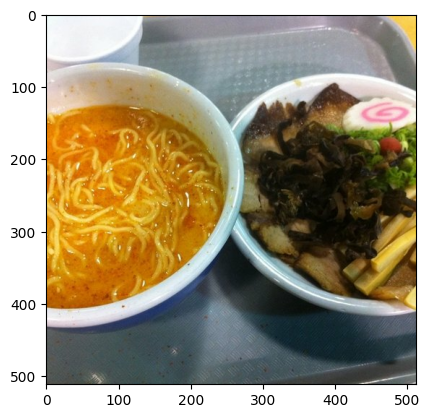

In [ ]:
plt.imshow(image)

In [ ]:
image = tf.cast(tf.expand_dims(image,0),tf.float32)
image /= 255.0

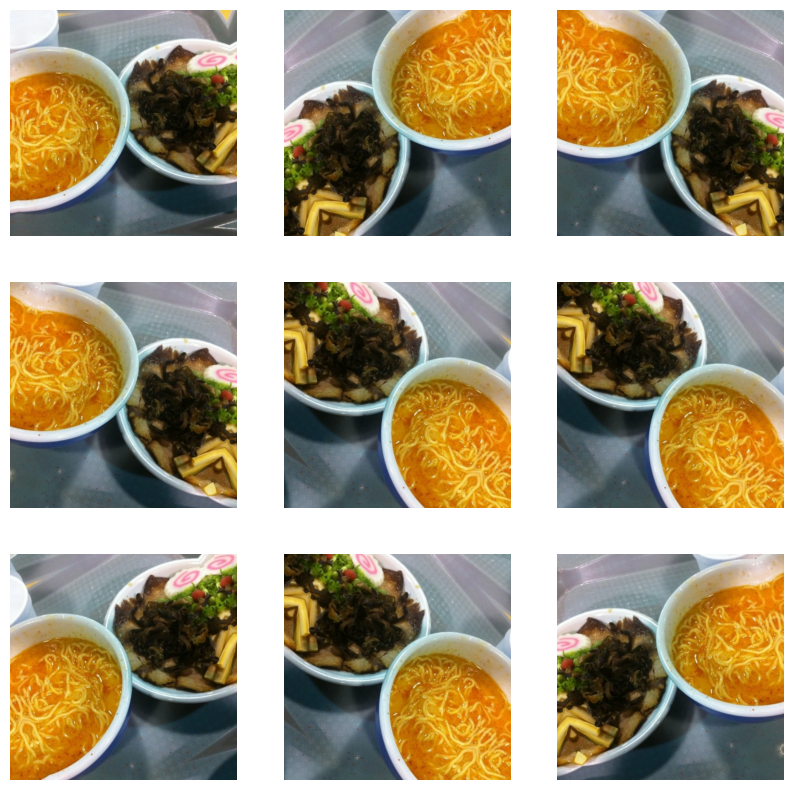

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax =  plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN,3]))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))



In [ ]:
lr=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=50
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs = epochs,
    verbose=1
)

Epoch 1/50
277/277 [==============================] - 863s 3s/step - loss: 1.4376 - accuracy: 0.4948 - val_loss: 1.1772 - val_accuracy: 0.4966
Epoch 2/50
277/277 [==============================] - 285s 1s/step - loss: 1.0352 - accuracy: 0.5018 - val_loss: 0.9217 - val_accuracy: 0.4980
Epoch 3/50
277/277 [==============================] - 276s 996ms/step - loss: 0.8670 - accuracy: 0.5185 - val_loss: 0.8148 - val_accuracy: 0.5060
Epoch 4/50
277/277 [==============================] - 281s 1s/step - loss: 0.7910 - accuracy: 0.5287 - val_loss: 0.7638 - val_accuracy: 0.5107
Epoch 5/50
277/277 [==============================] - 280s 1s/step - loss: 0.7500 - accuracy: 0.5484 - val_loss: 0.7272 - val_accuracy: 0.5638
Epoch 6/50
277/277 [==============================] - 279s 1s/step - loss: 0.7275 - accuracy: 0.5540 - val_loss: 0.7089 - val_accuracy: 0.5409
Epoch 7/50
277/277 [==============================] - 275s 993ms/step - loss: 0.7095 - accuracy: 0.5611 - val_loss: 0.6942 - val_accuracy: 

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in valid_ds.take(1):
  image = image_batch
  label = label_batch

<Figure size 1000x1000 with 0 Axes>

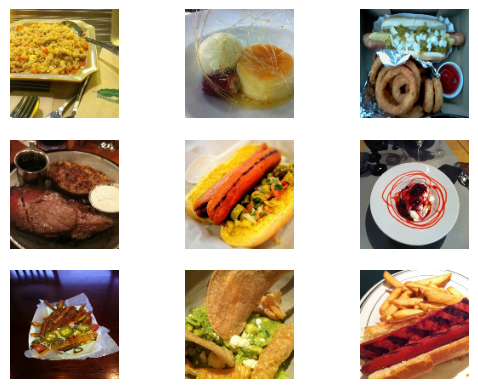

In [ ]:
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[i])
  plt.axis("off")

In [ ]:
label[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 1, 0, 1, 0, 1, 0, 1], dtype=int32)>